In [46]:
import numpy as np
import pandas as pd
pd.options.display.max_rows = 15
pd.options.display.max_columns = 15

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from plotly import graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torchmetrics
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [47]:
Data = pd.read_csv('../input/particle-precipitate-flux-prediction-original-data/AI_Ready_DMSP_Data.csv',
                   parse_dates=['Datetimes'])
# Data.drop(columns=['Unnamed: 0'],inplace=True)
Data

,Datetimes,SC_AACGM_LAT,SC_AACGM_LTIME,ELE_TOTAL_ENERGY_FLUX,ELE_TOTAL_ENERGY_FLUX_STD,ELE_AVG_ENERGY,ELE_AVG_ENERGY_STD,...,SymH_5min,PC_5min,vsw_5min,vx_5min,psw_5min,borovsky_5min,newell_5min
0,1987-01-12 12:57:00,51.143220,5.664024,2.057827e+08,0.411230,39.89341,0.411485,...,3.0,0.77,356.0,-355.5,2.96,17439.640589,2489.686963
1,1987-01-12 12:58:00,54.137207,5.535848,2.509837e+08,0.478268,40.82392,0.478568,...,3.0,0.77,356.0,-355.5,2.96,17439.640589,2489.686963
2,1987-01-12 13:01:00,62.928176,5.031172,4.469146e+08,0.603362,143.77360,0.604023,...,3.0,0.77,354.7,-354.1,3.20,14199.368957,1847.748015
3,1987-01-12 13:02:00,65.719631,4.794780,1.934849e+10,0.103648,820.36560,0.103671,...,3.0,0.77,354.7,-354.1,3.20,14199.368957,1847.748015
4,1987-01-12 13:03:00,68.392364,4.507448,3.913337e+11,0.114959,5291.57100,0.114959,...,3.0,0.77,354.7,-354.1,3.20,14199.368957,1847.748015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1945882,2014-12-31 22:50:00,57.581441,19.667482,2.231577e+08,0.196140,39.70994,0.274218,...,-11.0,-0.12,528.8,-528.3,2.14,8055.887423,622.199021
1945883,2014-12-31 22:51:00,54.923541,19.585868,3.074197e+08,0.190974,42.31005,0.257437,...,-11.0,-0.12,528.8,-528.3,2.14,8055.887423,622.199021
1945884,2014-12-31 22:52:00,52.270565,19.512302,1.917582e+08,0.221838,41.81216,0.299996,...,-11.0,-0.12,528.8,-528.3,2.14,8055.887423,622.199021
1945885,2014-12-31 22:53:00,49.619169,19.445679,2.265864e+08,0.203549,39.70088,0.278064,...,-11.0,-0.12,528.8,-528.3,2.14,8055.887423,622.199021


# Compressing Data

In [48]:
# for col in Data.columns:
#     col_type = Data[col].dtype

#     if col_type != object:
#         c_min = Data[col].min()
#         c_max = Data[col].max()
#         if str(col_type)[:3] == 'int':
#             if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
#                 Data[col] = Data[col].astype(np.int8)
#             elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
#                 Data[col] = Data[col].astype(np.int16)
#             elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
#                 Data[col] = Data[col].astype(np.int32)
#             elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
#                 Data[col] = Data[col].astype(np.int64)  
#         else:
#             if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
#                 Data[col] = Data[col].astype(np.float16)
#             elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
#                 Data[col] = Data[col].astype(np.float32)
#             else:
#                 Data[col] = Data[col].astype(np.float64)
#     else:
#         Data[col] = Data[col].astype('category')
        
# Data

Dropping Uneccesary Features

In [49]:
# Choose columns to drop
cols_to_drop = [c for c in Data.columns if ('1min' in c) | ('3min' in c) | ('4min' in c) | ('_5min'in c) | ('15min' in c)| ('5hr' in c) | ('F107_' in c) | ('vx' in c) | ('AE' in c) | ('newell' in c) | ('borovsky' in c) | ('STD' in c) | ('AVG' in c) | ('SC_AACGM_LTIME'==c)]
Data.drop(columns=cols_to_drop, inplace=True)

In [50]:
# Data.info()
# Data.columns.to_list()

# Sampling the Data using subset (constant step) 

In [51]:
Data.sort_values(by="ELE_TOTAL_ENERGY_FLUX",inplace=True)

rate = 7
subset = Data[::rate]
subset.shape

(277984, 74)

In [52]:
# no_of_bins = 250
# bin_size = int((np.log(Data["ELE_TOTAL_ENERGY_FLUX"]).max()-np.log(Data["ELE_TOTAL_ENERGY_FLUX"]).min())/no_of_bins)
# columns = ['Full ELE_TOTAL_ENERGY_FLUX', "Subset ELE_TOTAL_ENERGY_FLUX"]
# fig = ff.create_distplot([np.log(Data["ELE_TOTAL_ENERGY_FLUX"]),np.log(subset["ELE_TOTAL_ENERGY_FLUX"])],columns,bin_size=bin_size, show_hist=True, show_rug=False)
# fig.layout.update({'title': 'Target Feature: ELE_TOTAL_ENERGY_FLUX (Log values)'})
# fig.show()

In [53]:
subset.to_csv('Data_Constant_rate7_Sample.csv')

Data = subset
subset = 0
Data

,Datetimes,SC_AACGM_LAT,ELE_TOTAL_ENERGY_FLUX,ID_SC,sin_ut,cos_ut,sin_doy,...,Bx_10min,AL_10min,AU_10min,SymH_10min,PC_10min,vsw_10min,psw_10min
1276630,2010-05-27 08:31:00,47.643953,2.632692e+06,18.0,0.790690,-0.612217,0.573772,...,1.78,-32.0,45.0,-5.0,0.51,348.4,0.91
1266009,2010-03-27 00:12:00,61.490655,2.632692e+06,18.0,0.052336,0.998630,0.995919,...,-1.88,-147.0,24.0,-9.0,1.89,433.4,0.91
1263741,2010-03-17 02:14:00,55.785685,2.632692e+06,18.0,0.551937,0.833886,0.965740,...,1.22,-23.0,16.0,5.0,0.55,459.6,2.49
1276873,2010-05-27 22:31:00,51.079601,2.632692e+06,18.0,-0.378649,0.925541,0.573772,...,-0.57,-24.0,31.0,3.0,0.35,319.8,0.99
1279029,2010-06-06 06:26:00,54.273862,2.632692e+06,18.0,0.993572,-0.113203,0.425000,...,2.78,-162.0,124.0,-21.0,1.01,475.1,0.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560733,2004-09-24 04:14:00,58.095508,3.988854e+15,14.0,0.894934,0.446198,-0.995105,...,0.83,-103.0,68.0,-22.0,1.20,412.8,1.26
871863,2006-03-04 16:44:00,86.142323,4.821219e+15,13.0,-0.945519,-0.325568,0.884068,...,0.86,-13.0,11.0,-4.0,0.66,357.5,2.02
35724,2001-08-16 12:15:00,59.040848,6.534921e+15,13.0,-0.065403,-0.997859,-0.705584,...,0.59,-39.0,22.0,-1.0,1.01,339.8,0.66
869813,2006-02-24 19:34:00,68.032697,1.015398e+16,13.0,-0.917060,0.398749,0.811539,...,3.28,-10.0,13.0,-12.0,0.53,422.6,1.18


# Checking Null Values

In [54]:
# def missing( df ):
# #     high_missing_values_features = []
# #     missing_values_features_less_5 = []
# #     missing_values_features_btw_5_and_40 = []
#     missing_values_features = []
#     for column in df.columns.values:
#         print( "Feature:- ", column )
#         percent_missing = df[column].isnull().sum()/df[column].shape[0]*100
#         print('Percentage of Missing Values:- ', percent_missing )
    
# #         if percent_missing>=25:
# #             high_missing_values_features.append( column )
# #         elif percent_missing<=40:
# #             missing_values_features_less_5.append( column )
# #         elif percent_missing>5 & percent_missing<=40:
# #             missing_values_features_btw_5_and_25.append( column )
#         print("--------------------------------------------------------------")
#         print("\n")
#     return # missing_values_features_less_5, missing_values_features_btw_5_and_40,  high_missing_values_features

# missing(Data)

No Null Values are present

In [55]:
# dropping one null row in validation set
Data.dropna(inplace=True)

Plotting Target

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:xlabel='ELE_TOTAL_ENERGY_FLUX', ylabel='Density'>

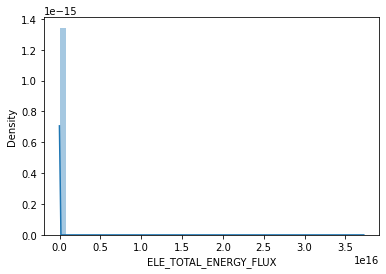

In [56]:
# fig = ff.create_distplot([ Data['ELE_TOTAL_ENERGY_FLUX']],['ELE_TOTAL_ENERGY_FLUX'], 
#                               bin_size= (Data['ELE_TOTAL_ENERGY_FLUX'].max() - Data['ELE_TOTAL_ENERGY_FLUX'].min())/50 ,
#                               show_hist=True, show_rug=True)
# fig.layout.update({'title': 'Delta Eta' })
# fig.show()

sns.distplot(Data['ELE_TOTAL_ENERGY_FLUX'])

Target Variable is Highly Skewed

Define the threshold above which to remove energy flux values

In [57]:
eflux_threshold_quantile = 99.995
eflux_threshold = 0.99995

erg_eV_factor = (1.60218e-12) # Conversion factor from eV to erg

Removing Outliers from Target Variable

In [58]:
"Threshold"
Upper_Threshold = np.percentile(Data['ELE_TOTAL_ENERGY_FLUX'], eflux_threshold_quantile )
print("Old Shape: ", Data.shape)

"Removing the Outliers"
Data = Data[ (Data['ELE_TOTAL_ENERGY_FLUX'].values < Upper_Threshold )]
print("New Shape: ", Data.shape)

Old Shape:  (277984, 74)
New Shape:  (277970, 74)


In [59]:
Data.set_index(keys=["Datetimes"], drop=True, inplace=True)

In [60]:
Data

,SC_AACGM_LAT,ELE_TOTAL_ENERGY_FLUX,ID_SC,sin_ut,cos_ut,sin_doy,cos_doy,...,Bx_10min,AL_10min,AU_10min,SymH_10min,PC_10min,vsw_10min,psw_10min
Datetimes,,,,,,,,,,,,,,,
2010-05-27 08:31:00,47.643953,2.632692e+06,18.0,0.790690,-0.612217,0.573772,-0.819015,...,1.78,-32.0,45.0,-5.0,0.51,348.4,0.91
2010-03-27 00:12:00,61.490655,2.632692e+06,18.0,0.052336,0.998630,0.995919,0.090252,...,-1.88,-147.0,24.0,-9.0,1.89,433.4,0.91
2010-03-17 02:14:00,55.785685,2.632692e+06,18.0,0.551937,0.833886,0.965740,0.259512,...,1.22,-23.0,16.0,5.0,0.55,459.6,2.49
2010-05-27 22:31:00,51.079601,2.632692e+06,18.0,-0.378649,0.925541,0.573772,-0.819015,...,-0.57,-24.0,31.0,3.0,0.35,319.8,0.99
2010-06-06 06:26:00,54.273862,2.632692e+06,18.0,0.993572,-0.113203,0.425000,-0.905193,...,2.78,-162.0,124.0,-21.0,1.01,475.1,0.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002-12-16 01:05:00,50.122056,2.443555e+13,13.0,0.279829,0.960050,-0.255353,0.966848,...,-0.92,-98.0,30.0,-17.0,0.08,520.5,1.70
2014-10-01 10:28:00,66.938744,2.764382e+13,17.0,0.390731,-0.920505,-0.999991,0.004304,...,-1.02,-127.0,93.0,-21.0,1.36,374.6,1.22
2001-10-10 02:32:00,47.631455,3.388328e+13,12.0,0.615661,0.788011,-0.987349,0.158559,...,-4.18,-103.0,30.0,-27.0,1.08,412.1,0.78


# Train Test Split

In [61]:
X_train, X_test, y_train, y_test = train_test_split( Data.drop(['ELE_TOTAL_ENERGY_FLUX'], axis=1), Data[['ELE_TOTAL_ENERGY_FLUX']], 
                                                        test_size=0.25, random_state=10)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((208477, 72), (69493, 72), (208477, 1), (69493, 1))

Normalization

In [62]:
scaler = StandardScaler()
scaler.fit(X_train) 
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test),  columns=X_train.columns)

Removing the steradian from the DMSP data BEFORE training

In [63]:
# The units of the energy flux are eV/cm2/s/ster
#   --> To remove the 'steradian' multiply by PI (see: https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1002/2016JA023339)
y_train = y_train*np.pi
y_test = y_test*np.pi

y_train = y_train.copy(deep=True)*(1.60218e-12)
y_test = y_test.copy(deep=True)*(1.60218e-12)

# Create targets in log10(eV/cm2/s) units to explore target in different units
y_train[y_train == 0] = 0.00001
y_test[y_test == 0] = 0.00001

Log-transforming the target

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:xlabel='ELE_TOTAL_ENERGY_FLUX', ylabel='Density'>

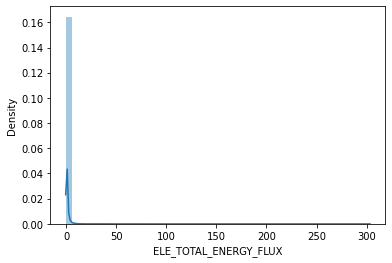

In [64]:
sns.distplot(y_train['ELE_TOTAL_ENERGY_FLUX'])

In [65]:
y_train['ELE_TOTAL_ENERGY_FLUX'] = y_train['ELE_TOTAL_ENERGY_FLUX'].apply(lambda x: np.log10(x))
y_test['ELE_TOTAL_ENERGY_FLUX'] = y_test['ELE_TOTAL_ENERGY_FLUX'].apply(lambda x: np.log10(x))

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:xlabel='ELE_TOTAL_ENERGY_FLUX', ylabel='Density'>

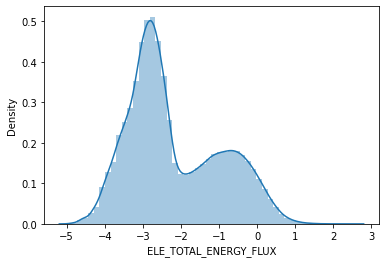

In [66]:
sns.distplot(y_train['ELE_TOTAL_ENERGY_FLUX'])

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:xlabel='ELE_TOTAL_ENERGY_FLUX', ylabel='Density'>

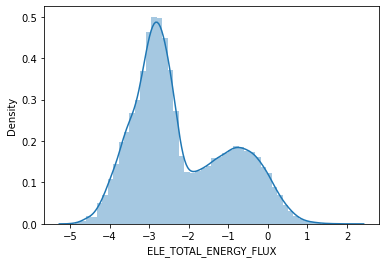

In [67]:
sns.distplot(y_test['ELE_TOTAL_ENERGY_FLUX'])

***

# Keras Tuner ANN Model

Some Functions for Graph plotting

In [24]:
def Plot_Loss_Accuracy( history, epochs ):
    loss = history.history['root_mean_squared_error']
    val_loss = history.history['val_root_mean_squared_error']

    epochs = np.linspace(1,epochs,epochs)
    epochs

    fig = go.Figure(data=go.Scatter( x=epochs, y=loss, name='Root_Mean_Squared_Error' ))
    fig.add_trace( go.Scatter( x=epochs, y=val_loss, name='Val_Root_Mean_Squared_Error' ) )
    fig.update_layout( title="Root Mean Squared Error", xaxis_title='epochs' )
    fig.update_layout(legend=dict( orientation="h", yanchor="bottom", y=1.02, xanchor="right",  x=1), width=1000, height=750)    
    fig.show()

### Deep Neural Network

In [25]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

# Function for calculation of R2-score
from tensorflow.keras import backend as K
def r2_score(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def adj_r2_score(y_true, y_pred, n, k):
    adj_r2 = 1 - ( ((n-1)/(n-k-1))*(1-r2_score(y_true, y_pred)) )
    return

In [26]:
# def hypertuning_model(hp):
    
#     model = Sequential()
#     model.add( InputLayer( input_shape=X_train.shape[1] ))
    
# #     lstm = hp.Choice('LSTM',values=["Yes","No"] )
# #     if lstm =="Yes":
# #         model.add( LSTM( 500, return_sequences=False ) ) 

#     number_of_layers = hp.Int('No_of_Layers',min_value=2,max_value=5)
#     for num_layer in range(1, number_of_layers+1 ):
#         model.add( Dense( hp.Int('layer'+str(num_layer), min_value=100, max_value=500, step=50),
#                              kernel_initializer=hp.Choice('kernel_initializer',values=['glorot_uniform','normal']) ,
#                              activation=tf.keras.layers.LeakyReLU(alpha=hp.Float('alpha'+str(num_layer), min_value=0.01, max_value=0.16, step=0.05))))
#         model.add( Dropout( hp.Choice('rate',values=[0.0,0.1,0.2,0.3] )))
#         # model.add( BatchNormalization() )'uniform'
        
#     model.add(Dense(1, activation='linear'))
#     model.compile(loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError(),
#                                        tf.keras.metrics.MeanSquaredLogarithmicError(),r2_score],
#                   optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-1,1e-2, 1e-3, 1e-4])))
    
#     return model

In [27]:
# hyper_tuned_model = kt.Hyperband( hypertuning_model, objective='val_loss',overwrite=True, max_epochs=50,seed=10 )
# call_back_ES = EarlyStopping(monitor='val_loss',patience=5)
# call_back_MCP = tf.keras.callbacks.ModelCheckpoint(filepath="./", monitor='val_loss', save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')
# hyper_tuned_model.search( X_train,y_train, validation_data=(X_test,y_test), epochs=50, callbacks=[call_back_ES,call_back_MCP], batch_size=64 )

Trial 90 Complete [00h 13m 04s] <br>
val_loss: 0.4460366368293762 

Best val_loss So Far: 0.4460366368293762 <br>
Total elapsed time: 02h 49m 09s

In [28]:
# best_hyperparameters = hyper_tuned_model.get_best_hyperparameters(num_trials=1)[0]
# best_hyperparameters.values

* {'No_of_Layers': 4,
*  'layer1': 350,
*  'kernel_initializer': 'glorot_uniform',
*  'alpha1': 0.060000000000000005,
*  'rate': 0.2,
*  'layer2': 200,
*  'alpha2': 0.060000000000000005,
*  'learning_rate': 0.0001,
*  'layer3': 300,
*  'alpha3': 0.11,
*  'layer4': 150,
*  'alpha4': 0.16000000000000003,
*  'layer5': 350,
*  'alpha5': 0.11,
*  'tuner/epochs': 50,
*  'tuner/initial_epoch': 0,
*  'tuner/bracket': 0,
*  'tuner/round': 0}

***

Training Best DNN Model with large no. of epoch

In [29]:
# Neural network
model_DNN = Sequential()
model_DNN.add( InputLayer( input_shape=X_train.shape[1] ))
model_DNN.add(Dense(350, activation=tf.keras.layers.LeakyReLU(alpha=0.06)))
model_DNN.add( Dropout(0.2))
model_DNN.add(Dense(200, activation=tf.keras.layers.LeakyReLU(alpha=0.06)))
model_DNN.add( Dropout(0.2))
model_DNN.add(Dense(300, activation=tf.keras.layers.LeakyReLU(alpha=0.11)))
model_DNN.add( Dropout(0.2))
model_DNN.add(Dense(150, activation=tf.keras.layers.LeakyReLU(alpha=0.16)))
model_DNN.add( Dropout(0.2))
model_DNN.add(Dense(350, activation=tf.keras.layers.LeakyReLU(alpha=0.11)))
model_DNN.add( Dropout(0.2))
model_DNN.add(Dense(1, activation='linear'))
model_DNN.compile(loss='mean_squared_error' , optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                    metrics=[tf.keras.metrics.RootMeanSquaredError(),
                             tf.keras.metrics.MeanSquaredLogarithmicError(),
                             r2_score])


call_back_ES = EarlyStopping(monitor='val_loss',patience=10)
call_back_MCP = tf.keras.callbacks.ModelCheckpoint(filepath="./", monitor='val_loss', save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')
tensorboard_callback = tf.keras.callbacks.TensorBoard("logs")

history = model_DNN.fit(X_train,y_train, validation_data=(X_test,y_test), epochs=125, callbacks=[call_back_ES,call_back_MCP,tensorboard_callback], batch_size=64 )

model_DNN.save("model_DNN.h5")
Plot_Loss_Accuracy( history, epochs=125 )

2022-12-03 04:52:23.717970: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-03 04:52:23.719195: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-03 04:52:23.719873: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-03 04:52:23.720738: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Epoch 1/125
   1/3258 [..............................] - ETA: 1:25:02 - loss: 6.5002 - root_mean_squared_error: 2.5496 - mean_squared_logarithmic_error: 0.0095 - r2_score: -4.2643

2022-12-03 04:52:31.562273: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-12-03 04:52:31.562331: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


   3/3258 [..............................] - ETA: 23:28 - loss: 4.4760 - root_mean_squared_error: 2.1156 - mean_squared_logarithmic_error: 0.0059 - r2_score: -2.2717 

2022-12-03 04:52:32.222016: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-12-03 04:52:32.223012: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-12-03 04:52:32.361879: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 165 callback api events and 160 activity events. 
2022-12-03 04:52:32.368752: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-12-03 04:52:32.381118: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/plugins/profile/2022_12_03_04_52_32

2022-12-03 04:52:32.385047: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_12_03_04_52_32/f212ab241911.trace.json.gz
2022-12-03 04:52:32.401999: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/plug

3258/3258 [==============================] - 16s 5ms/step - loss: 0.7526 - root_mean_squared_error: 0.8675 - mean_squared_logarithmic_error: 0.0056 - r2_score: 0.4766 - val_loss: 0.5529 - val_root_mean_squared_error: 0.7436 - val_mean_squared_logarithmic_error: 0.0053 - val_r2_score: 0.6170


2022-12-03 04:52:46.932452: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/125
3258/3258 [==============================] - 13s 4ms/step - loss: 0.5939 - root_mean_squared_error: 0.7706 - mean_squared_logarithmic_error: 0.0056 - r2_score: 0.5873 - val_loss: 0.5263 - val_root_mean_squared_error: 0.7254 - val_mean_squared_logarithmic_error: 0.0053 - val_r2_score: 0.6356
Epoch 3/125
3258/3258 [==============================] - 14s 4ms/step - loss: 0.5686 - root_mean_squared_error: 0.7540 - mean_squared_logarithmic_error: 0.0056 - r2_score: 0.6043 - val_loss: 0.5491 - val_root_mean_squared_error: 0.7410 - val_mean_squared_logarithmic_error: 0.0053 - val_r2_score: 0.6203
Epoch 4/125
3258/3258 [==============================] - 12s 4ms/step - loss: 0.5527 - root_mean_squared_error: 0.7435 - mean_squared_logarithmic_error: 0.0055 - r2_score: 0.6151 - val_loss: 0.5104 - val_root_mean_squared_error: 0.7144 - val_mean_squared_logarithmic_error: 0.0051 - val_r2_score: 0.6460
Epoch 5/125
3258/3258 [==============================] - 13s 4ms/step - loss: 0.5389 - r

### LSTM

In [30]:
X_train = X_train.to_numpy().reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.to_numpy().reshape((X_test.shape[0], 1, X_test.shape[1]))

In [31]:
# def hypertuning_model(hp):
    
#     model = Sequential()
#     model.add( InputLayer( input_shape=(X_train.shape[1],X_train.shape[2] )))

#     model.add( LSTM( hp.Choice('LSTM_Units',values=[100,250,500] ), return_sequences=False ) ) 

#     number_of_layers = hp.Int('No_of_Layers',min_value=2,max_value=5)
#     for num_layer in range(1, number_of_layers+1 ):
#         model.add( Dense( hp.Int('layer'+str(num_layer)+" units", min_value=50, max_value=500, step=50),
#                              kernel_initializer=hp.Choice('kernel_initializer',values=['glorot_uniform']) ,
#                              activation=tf.keras.layers.LeakyReLU(alpha=hp.Float('alpha'+str(num_layer), min_value=0.01, max_value=0.16, step=0.05))))
#         model.add( Dropout( hp.Choice('rate',values=[0.0,0.1,0.2,0.3] )))
#         # model.add( BatchNormalization() )'uniform'
        
#     model.add(Dense(1, activation='linear'))
#     model.compile(loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError(), r2_score],
#                   optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[ 1e-2, 1e-3, 1e-4])))
    
#     return model

In [32]:
# hyper_tuned_model = kt.Hyperband( hypertuning_model, objective='val_loss',overwrite=True, max_epochs=50,seed=10 )
# call_back_ES = EarlyStopping(monitor='val_loss',patience=5)
# call_back_MCP = tf.keras.callbacks.ModelCheckpoint(filepath="./", monitor='val_loss', save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')
# hyper_tuned_model.search( X_train,y_train, validation_data=(X_test,y_test), epochs=50, callbacks=[call_back_ES,call_back_MCP], batch_size=64 )

Trial 90 Complete [00h 07m 44s] <br>
val_loss: 0.4626578986644745

Best val_loss So Far: 0.4487108290195465 <br>
Total elapsed time: 04h 36m 30s

In [33]:
# best_hyperparameters = hyper_tuned_model.get_best_hyperparameters(num_trials=1)[0]
# best_hyperparameters.values

* {'LSTM_Units': 100,
*  'No_of_Layers': 4,
*  'layer1 units': 450,
*  'kernel_initializer': 'glorot_uniform',
*  'alpha1': 0.01,
*  'rate': 0.0,
*  'layer2 units': 300,
*  'alpha2': 0.01,
*  'learning_rate': 0.001,
*  'layer3 units': 100,
*  'alpha3': 0.16000000000000003,
*  'layer4 units': 250,
*  'alpha4': 0.01,
*  'layer5 units': 450,
*  'alpha5': 0.11,
*  'tuner/epochs': 50,
*  'tuner/initial_epoch': 17,
*  'tuner/bracket': 2,
*  'tuner/round': 2,
*  'tuner/trial_id': '0067'}

In [34]:
# LSTM Neural network
model_LSTM_NN = Sequential()
model_LSTM_NN.add( InputLayer( input_shape=(X_train.shape[1],X_train.shape[2] )))
model_LSTM_NN.add( LSTM( 100, return_sequences=False ))
model_LSTM_NN.add(Dense(450, activation=tf.keras.layers.LeakyReLU(alpha=0.01)))
model_LSTM_NN.add(Dense(300, activation=tf.keras.layers.LeakyReLU(alpha=0.01)))
model_LSTM_NN.add(Dense(100, activation=tf.keras.layers.LeakyReLU(alpha=0.16)))
model_LSTM_NN.add(Dense(250, activation=tf.keras.layers.LeakyReLU(alpha=0.01)))
model_LSTM_NN.add(Dense(450, activation=tf.keras.layers.LeakyReLU(alpha=0.11)))
model_LSTM_NN.add(Dense(1, activation='linear'))
model_LSTM_NN.compile(loss='mean_squared_error' , optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                    metrics=[tf.keras.metrics.RootMeanSquaredError(),tf.keras.metrics.MeanSquaredLogarithmicError(),r2_score])

call_back_ES = EarlyStopping(monitor='val_loss',patience=10)
call_back_MCP = tf.keras.callbacks.ModelCheckpoint(filepath="./", monitor='val_loss', save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')
# tensorboard_callback = tf.keras.callbacks.TensorBoard("logs")
history = model_LSTM_NN.fit(X_train,y_train, validation_data=(X_test,y_test), epochs=100, callbacks=[call_back_ES,call_back_MCP], batch_size=64 )

model_LSTM_NN.save("model_LSTM_NN.h5")
Plot_Loss_Accuracy( history, epochs=100)

Epoch 1/100


2022-12-03 04:57:55.234535: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


3258/3258 [==============================] - 18s 5ms/step - loss: 0.6210 - root_mean_squared_error: 0.7880 - mean_squared_logarithmic_error: 0.0056 - r2_score: 0.5685 - val_loss: 0.5274 - val_root_mean_squared_error: 0.7262 - val_mean_squared_logarithmic_error: 0.0052 - val_r2_score: 0.6338
Epoch 2/100
3258/3258 [==============================] - 16s 5ms/step - loss: 0.4996 - root_mean_squared_error: 0.7068 - mean_squared_logarithmic_error: 0.0055 - r2_score: 0.6522 - val_loss: 0.5040 - val_root_mean_squared_error: 0.7099 - val_mean_squared_logarithmic_error: 0.0048 - val_r2_score: 0.6507
Epoch 3/100
3258/3258 [==============================] - 16s 5ms/step - loss: 0.4740 - root_mean_squared_error: 0.6885 - mean_squared_logarithmic_error: 0.0054 - r2_score: 0.6702 - val_loss: 0.4665 - val_root_mean_squared_error: 0.6830 - val_mean_squared_logarithmic_error: 0.0052 - val_r2_score: 0.6767
Epoch 4/100
3258/3258 [==============================] - 15s 5ms/step - loss: 0.4561 - root_mean_squ

***
***

# Neural Network using Pytorch

Dataset for PyTorch

In [68]:
class Train(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
    def __len__ (self):
        return len(self.X_data)

class Test(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
    def __len__ (self):
        return len(self.X_data)
    
########################

train_data = Train(torch.FloatTensor(X_train.values), torch.FloatTensor(y_train.values))
test_data = Test(torch.FloatTensor(X_test.values), torch.FloatTensor(y_test.values))

########################

train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=64)

Neural Network

In [69]:
class NN_Model(nn.Module):
    def __init__(self):
        super(NN_Model, self).__init__()

        input_size = X_train.shape[1]   # The number of variables in your sequence data. 
#         n_hidden   = 100  # The number of hidden nodes in the LSTM layer.
#         n_layers   = 1    # The total number of LSTM models layers
#         out_size   = 450    # The size of the output you desire from your RNN
#         self.layer_1 = nn.LSTM(input_size, n_hidden, n_layers)
#         self.linear_lstm = nn.Linear(n_hidden, out_size)

        self.layer_1 = nn.Linear(input_size, 350)
        self.act1 = nn.LeakyReLU(0.06)
        self.dropout_1 = nn.Dropout(p=0.2)

        self.layer_2 = nn.Linear(350,200)
        self.act2 = nn.LeakyReLU(0.06)
        self.dropout_2 = nn.Dropout(p=0.2)
        
        self.layer_3 = nn.Linear(200, 300)
        self.act3 = nn.LeakyReLU(0.11)
        self.dropout_3 = nn.Dropout(p=0.2)
        
        self.layer_4 = nn.Linear(300, 150)
        self.act4 = nn.LeakyReLU(0.16)
        self.dropout_4 = nn.Dropout(p=0.2)
        
        self.layer_5 = nn.Linear(150, 350)
        self.act5 = nn.LeakyReLU(0.11)
        self.dropout_5 = nn.Dropout(p=0.2)
        
        self.layer_6 = nn.Linear(350, 1)
        
        self.layer_out = nn.Linear(1, 1) 
        
#        self.relu = nn.ReLU()
    
    def forward(self, inputs):
        x = self.layer_1(inputs)
        x = self.act1(x)
        x = self.dropout_1(x)
        x = self.layer_2(x)
        x = self.act2(x)
        x = self.dropout_2(x)
        x = self.layer_3(x)
        x = self.act3(x)
        x = self.dropout_3(x)
        x = self.layer_4(x)
        x = self.act4(x)
        x = self.dropout_4(x)
        x = self.layer_5(x)
        x = self.act5(x)
        x = self.dropout_5(x)
        x = self.layer_6(x)
        # x = self.act6(x)
        x = self.layer_out(x)
        return x

    
    def forward(self, test_inputs):
        x = self.dropout_1(self.act1(self.layer_1(test_inputs)))
        x = self.dropout_2(self.act2(self.layer_2(x)))
        x = self.dropout_3(self.act3(self.layer_3(x)))
        x = self.dropout_4(self.act4(self.layer_4(x)))
        x = self.dropout_5(self.act5(self.layer_5(x)))
        x = self.layer_6(x)
        x = self.layer_out(x)
        
        return x
    

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

##############

model = NN_Model()
model.to(device)
print(model)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

##############

cuda:0
NN_Model(
  (layer_1): Linear(in_features=72, out_features=350, bias=True)
  (act1): LeakyReLU(negative_slope=0.06)
  (dropout_1): Dropout(p=0.2, inplace=False)
  (layer_2): Linear(in_features=350, out_features=200, bias=True)
  (act2): LeakyReLU(negative_slope=0.06)
  (dropout_2): Dropout(p=0.2, inplace=False)
  (layer_3): Linear(in_features=200, out_features=300, bias=True)
  (act3): LeakyReLU(negative_slope=0.11)
  (dropout_3): Dropout(p=0.2, inplace=False)
  (layer_4): Linear(in_features=300, out_features=150, bias=True)
  (act4): LeakyReLU(negative_slope=0.16)
  (dropout_4): Dropout(p=0.2, inplace=False)
  (layer_5): Linear(in_features=150, out_features=350, bias=True)
  (act5): LeakyReLU(negative_slope=0.11)
  (dropout_5): Dropout(p=0.2, inplace=False)
  (layer_6): Linear(in_features=350, out_features=1, bias=True)
  (layer_out): Linear(in_features=1, out_features=1, bias=True)
)


Metric

In [70]:
def r2_score(y_true, y_pred):
    y_pred = y_pred.cpu().numpy()
    y_true = y_true.detach().cpu().numpy()
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - np.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

Train Neural Network

In [71]:
EPOCHS = 50

In [72]:
losss = []
epoch_losss = []
epoch_accc = []
accs = []

val_losss = []
val_epoch_losss = []
val_epoch_accc = []
val_accs = []

model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    val_epoch_loss = 0
    val_epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = r2_score(y_pred, y_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc
        losss.append(epoch_loss)
        accs.append(epoch_acc)
        
        
     # Validation
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
            y_pred = model(X_batch)
            
            loss = criterion(y_pred, y_batch)
            acc = r2_score(y_pred, y_batch)
        
            val_epoch_loss += loss.item()
            val_epoch_acc += acc
            val_losss.append(val_epoch_loss)
            val_accs.append(val_epoch_acc)
        
        
    epoch_losss.append(epoch_loss/len(train_loader))
    epoch_accc.append(epoch_acc/len(train_loader))
    
    val_epoch_losss.append(val_epoch_loss/len(test_loader))
    val_epoch_accc.append(val_epoch_acc/len(test_loader))

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(test_loader):.5f} | R2 Score: {epoch_acc/len(train_loader):.5f} | Val. R2 Score: {val_epoch_acc/len(test_loader):.5f}')

Epoch 001: | Loss: 0.77998 | Val Loss: 0.60537 | R2 Score: -297552.96875 | Val. R2 Score: 0.26785
Epoch 002: | Loss: 0.58031 | Val Loss: 0.55416 | R2 Score: 0.33306 | Val. R2 Score: 0.32946
Epoch 003: | Loss: 0.55427 | Val Loss: 0.54643 | R2 Score: 0.37237 | Val. R2 Score: 0.46332
Epoch 004: | Loss: 0.53416 | Val Loss: 0.52614 | R2 Score: 0.40543 | Val. R2 Score: 0.43395
Epoch 005: | Loss: 0.52158 | Val Loss: 0.52764 | R2 Score: 0.42740 | Val. R2 Score: 0.33624
Epoch 006: | Loss: 0.51289 | Val Loss: 0.51651 | R2 Score: 0.44060 | Val. R2 Score: 0.47956
Epoch 007: | Loss: 0.50501 | Val Loss: 0.51745 | R2 Score: 0.45439 | Val. R2 Score: 0.40830
Epoch 008: | Loss: 0.49727 | Val Loss: 0.52411 | R2 Score: 0.46628 | Val. R2 Score: 0.41661
Epoch 009: | Loss: 0.49308 | Val Loss: 0.50994 | R2 Score: 0.47178 | Val. R2 Score: 0.53952
Epoch 010: | Loss: 0.48660 | Val Loss: 0.50934 | R2 Score: 0.48285 | Val. R2 Score: 0.52314
Epoch 011: | Loss: 0.48395 | Val Loss: 0.49641 | R2 Score: 0.48836 | Val. 

In [73]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
layer_1.weight 	 torch.Size([350, 72])
layer_1.bias 	 torch.Size([350])
layer_2.weight 	 torch.Size([200, 350])
layer_2.bias 	 torch.Size([200])
layer_3.weight 	 torch.Size([300, 200])
layer_3.bias 	 torch.Size([300])
layer_4.weight 	 torch.Size([150, 300])
layer_4.bias 	 torch.Size([150])
layer_5.weight 	 torch.Size([350, 150])
layer_5.bias 	 torch.Size([350])
layer_6.weight 	 torch.Size([1, 350])
layer_6.bias 	 torch.Size([1])
layer_out.weight 	 torch.Size([1, 1])
layer_out.bias 	 torch.Size([1])
Optimizer's state_dict:
state 	 {0: {'step': 162900, 'exp_avg': tensor([[ 1.1378e-03, -6.8332e-04,  1.9248e-04,  ..., -1.9175e-04,
         -2.6340e-04, -1.4907e-03],
        [-5.9622e-05, -1.7285e-04,  3.7888e-04,  ..., -5.7027e-04,
          2.3345e-04, -4.2341e-04],
        [ 6.1800e-04,  2.9573e-05,  5.2090e-04,  ...,  2.9608e-04,
         -1.0208e-03, -5.9206e-04],
        ...,
        [ 7.0724e-04,  4.5562e-04, -2.9086e-04,  ...,  4.2610e-05,
          9.5827e-05,  

In [84]:
torch.save(model,"/kaggle/working/pytorch_model.pth")

Plot Loss and Accuracy

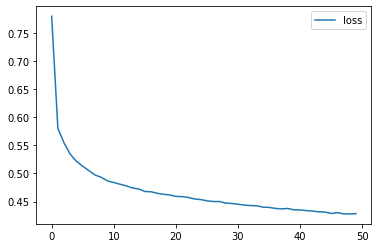

In [85]:
plt.plot(epoch_losss, label='loss')
plt.legend()
plt.show()

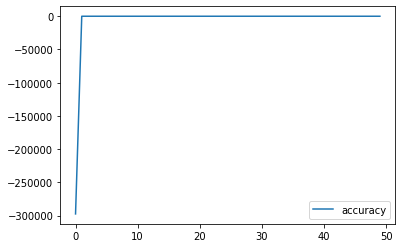

In [86]:
plt.plot(epoch_accc, label='accuracy')
plt.legend()
plt.show()